# CategoricalColumnTransformer

CategoricalColumnTransformer is a function for converting data frames containing one or more categorical columns which you would like to use to represent your data into variable length lists of tokens.  This format is far more conducive the the various vectorization techniques contained within this library (or other libraries).  This is often used as a preprocessing step to make a pandas data frame more palatable to downstream vectorizers such as our [NgramVectorizer](https://vectorizers.readthedocs.io/en/latest/generated/vectorizers.NgramVectorizer.html) or sklearn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).  Both these vectorizers expect data in the form of a variable length sequence of tokens.  In CountVectorizers case they typically expect these variable sequence to be joined together into a single large string that needs to be parsed.  Both these techniques convert from variable length sequences of tokens into a **[one hot encoding](https://en.wikipedia.org/wiki/One-hot#Natural_language_processing)** representation of our data.  That is to build a new column for each categorical variable name and value and then place a one in that new column if that particular value was present within a particular row.  More generally, that is a vector composed of 1's and 0's where the 1's are in positions representing the tokens present in a given sequence.  These vectors will by definition have length equal to the the number of unique tokens which exist within your corpus.  Because the vast majority of these vectors will be 0's (the vast majority of your tokens aren't present in any given sequence) sparse representations are particularly useful for this sort of data.  Sparse representation are those which only record the position of positive values and store the zero values implicitly.

There are other techniques for directly constructing these one hot representation.  Two of the most common are pandas' [get_dummies](https://pandas.pydata.org/pandas-docs/version/0.23.3/generated/pandas.get_dummies.html) function or scikit-learn's [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).  Both are fine functions, but for large amounts of data (particulary if some of your columns have many values) you really want to ensure that you keep good track of your column names and maintain a sparse matrix representation.  A sparse matrix representation is one where you never actually write down any of the zero values.  This is important in a one-hot encoded representation because you have one column for every single categorical value in your data set.  If, for example, one of your columns contained a name or phone number then you could easily have added hundreds of thousands of (mostly zero) columns to every row within your data matrix.  For even medium sized data sets this can quickly exceed your computers memory limit.  

## Import Some libraries¶

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from vectorizers.transformers import CategoricalColumnTransformer
from vectorizers import NgramVectorizer
from vectorizers.utils import summarize_embedding
import umap
import umap.plot
umap.plot.output_notebook()

Loading BokehJS ...

## Let’s fetch some data¶

To demonstrate how to use our CategoricalColumnTransformer we will need an interesting data set with a number of categorical features.  The wine reviews data set is an excllent example of such a thing.  It consists of 150,930 wine reviews along with the winery that made the wine, it's country, province, regions, wine variety and a few other variables.  This plethora of categorical values will allow us to demonstrate a typical use case for transformer.

In [2]:
from sklearn.datasets import fetch_openml
data_openml = fetch_openml('wine_reviews')
data = pd.DataFrame(data_openml.data)

/Users/jchealy/mambaforge/envs/vectorizers_build/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,150925,48,US,62397,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,150930,97821,A little bit funky and unsettled when you pop ...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,105195,30621,Reserve,2752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,150930.0,NaN,NaN,NaN,87.888418,3.222392,80.0,86.0,88.0,90.0,100.0
price,137235.0,NaN,NaN,NaN,33.131482,36.322536,4.0,16.0,24.0,40.0,2300.0
province,150925,455,California,44508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,125870,1236,Napa Valley,6209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,60953,18,Central Coast,13057,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,150930,632,Chardonnay,14482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,150930,14810,Williams Selyem,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Restructure our Data
### CategoricalColumnTransformer

The first thing we need to do when embedding any data is decide what the object we are going to be interested in embedding.  Given a dataset with many categorical values this isn't necessarily the rows of our data frame.  In this case we could certainly vectorizer and embed our wine reviews.  That would be straight forward with many existing techniques.  On the other hand, one could be equally interested in examining wine varieties or wineries.  In our CategoricalColumnTransformer the column that you are interested in treating as your object to examined should be specified by the parameter <code>object_column_name</code>.  For our example we will be interested in exploring the objects defined by our variety variable.  These are wine types such as Chardonnay, Pinot Noir, etc... 

Next we need to decide which labels should be used to describe our objects of interest.  The parameter in question would be <code>descriptor_column_name</code>. This is either a single string representing a column name or a list of string representing a collection of column names.  In this example we will describe our wine varieties by the regions in which they are made.  We  won't use the country variable so that we can save it for visualization.  In summary, we wish to described our wine varities by a cagorical vector of the regions in which they are made.  

Our next parameter of interesting is the boolean <code>include_column_name</code>.  This parameter controls whether each column name is appended before each column value or not.  When dealing with multiple columns which might contain identical tokens then one should likely include the column names in order to disambiguate between these tokens.  Of course there are many cases where there is no ambiguity and as such including such names just makes for cumbersome column names.  

Lastly, we have the boolean parameter <code>unique_values</code>.  Setting this to true uniques our list of tokens before returning it.  In this case we set it equal to <code>True</code> since we are looking at reviews of wines we would likely to eliminate any biases generated from the number of reviews a wine has received.    


In [4]:
transformer = CategoricalColumnTransformer(object_column_name='variety',descriptor_column_name=['province','region_1','region_2'], include_column_name=True, unique_values=True)
variety_by_location_list = transformer.fit_transform(data)

In [5]:
variety_by_location_list

variety
Agiorgitiko               [province:Nemea, province:Peloponnese, provinc...
Aglianico                 [province:California, province:Southern Italy,...
Aidani                                                  [province:Cyclades]
Airen                     [province:Central Spain, region_1:Vino de la T...
Albana                    [province:Alentejano, province:Central Italy, ...
                                                ...                        
Zierfandler-Rotgipfler                             [province:Thermenregion]
Zinfandel                 [province:California, province:Washington, pro...
Zlahtina                         [province:Krk, province:Hrvatsko Primorje]
Zweigelt                  [province:Carnuntum, province:Burgenland, prov...
Žilavka                                                   [province:Tikves]
Length: 632, dtype: object

<code>variety_by_location_list</code> is now a pandas Series with an index that is the variety and a value that is a list of the unique tokens which describe the varioius geographic areas that manufuacture that variety.

### Vectorize our data
Now that we've converted our data to sequences of tokens we can convert them into a our sparse one hot encoding format.  We can do this quite efficiently by using our [NgramVectorizer](https://vectorizers.readthedocs.io/en/latest/generated/vectorizers.NgramVectorizer.html).  This will convert from a series of of token lists into a one hot encoded sparse matrix format.

In [6]:
vectorizer = NgramVectorizer()
variety_matrix = vectorizer.fit_transform(variety_by_location_list)
variety_matrix

<632x1709 sparse matrix of type '<class 'numpy.float32'>'
	with 11459 stored elements in Compressed Sparse Row format>

variety_matrix is now a 632 by 1709 dimensional sparse matrix.  Each row represents one of our varieties and each column represents the presence or absence of one of our categorical values.  From the dimension we can see that there were 1709 unique categorical values across our columns of interest: ('province','region_1','region_2').

The column names can be accessed via the dictionaries: 
<code>vectorizer.column_label_dictionary_</code> or it's reversed dictionary <code>vectorizer.column_index_dictionary_</code>

## Look at your data

We will use our UMAP algorithm along with a few data enrichments to explore what this representation shows up about our wine varieties.  In order to move from a representation to an embedding we will also need to define a distance measure overtop of our vectors.  For the purposes of this notebook we will choose cosine distance.  It tends to perform fairly well in these high dimensional sparse spaces.  

More categorical distance measures such as jaccard or dice might have also been appropriate and might reveal subtly differnt structure within our data.

Now that we have a representation and a distance function we will use UMAP to embed our data into two dimensions for visualization.

In [7]:
reducer = umap.UMAP(n_neighbors=10, metric='cosine', random_state=17).fit(variety_matrix)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Let's enrich our data with some labels and extra data for exploring our embedding.  To do this we'll both make use of some basic pandas functionality but also introduce our <code>summarize_embedding</code> function.  <code>summarize_embedding</code> takes a matrix and a dictionary of column names and returns a label that consists of column names associated with the top k (defaults to 3) values in each row.  

We will colour our vertices by the country which contains the most wineries which produce that variety.

In [9]:
# Associate each variety with the country containing the most wineries which make that style
country_map =  data[['variety','winery','country']].drop_duplicates().groupby('variety').country.agg(lambda x:x.value_counts().index[0])
variety_labels = pd.Series(variety_by_location_list.index)
location_tags = summarize_embedding(variety_matrix, vectorizer.column_index_dictionary_, return_type='string')
hover_df = pd.DataFrame({'variety': variety_labels, 'location': location_tags, 'main_country':variety_labels.map(country_map) })

In [10]:
p = umap.plot.interactive(reducer, theme='fire', hover_data=hover_df, labels = variety_labels.map(country_map), width =600, height=600, point_size=3)
umap.plot.show(p)

We see good clustering and interesting structure induced on many of our wine varieties.  The varieties not surprisingly are grouped by regions. Interestingly, the predominantly Italian varieties split into at least 5 very disjoint clusters corresponding to different regions within Italy where wine varieties gain different labels depending on the specific region in which they are made.  

The main central cluster is composed of wine varieties that are made in a a wide range of countries such as Merlot-Cabernet Sauvignon, Shiraz or Port.  To support this hyothesis we will colour each variety with a heatmap indicating the number of countries which manufacture each wine.   

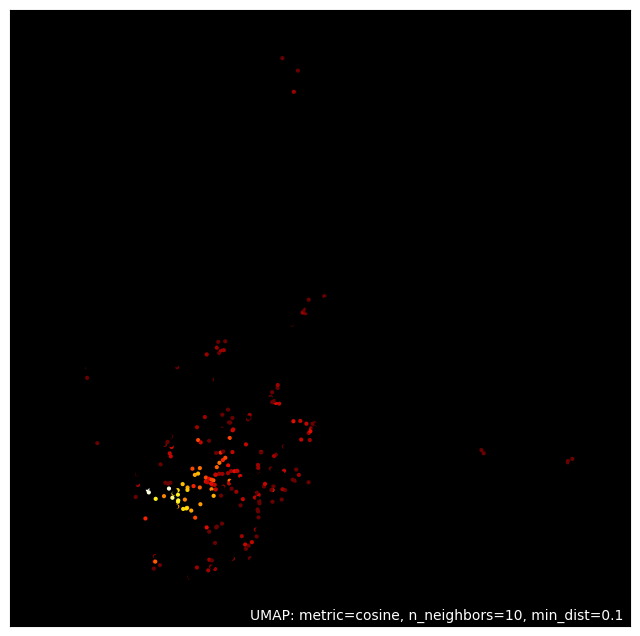

In [11]:
country_count = data[['variety','country']].drop_duplicates().groupby('variety').country.count()
umap.plot.points(reducer, theme='fire', values=np.log(variety_labels.map(country_count)));

If instead you were interested in a less course measure you might look at a heatmap of the number of wineries across the world which manufacture each variety.  The differences between these plots show that there are some varieties that are manufactured in many wineries but those wineries are only located within a single country.

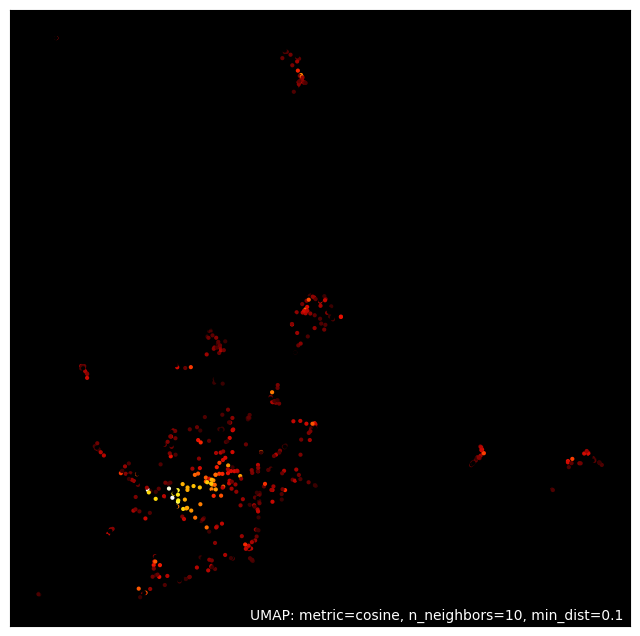

In [12]:
winery_count = data[['variety','winery']].drop_duplicates().groupby('variety').winery.count()
umap.plot.points(reducer, theme='fire', values=np.log(variety_labels.map(winery_count)));